## Group members
Oda Grauff Erntsen 490130

Marte Vingsnes 521488

Malin Døskeland 527204

Kaggle team name: The Data Divas

In [42]:
import os

In [43]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [44]:
root = os.getcwd()

## Load and process data

In [45]:
# Directory paths for each group of data
train_dirpath_A = os.path.join(root, "data", "A")
train_dirpath_B = os.path.join(root, "data", "B")
train_dirpath_C = os.path.join(root, "data", "C")

# pv_measurement for all training and validation rows
targets_a = pd.read_parquet(os.path.join(train_dirpath_A, 'train_targets.parquet'))
targets_b = pd.read_parquet(os.path.join(train_dirpath_B, 'train_targets.parquet'))
targets_c = pd.read_parquet(os.path.join(train_dirpath_C, 'train_targets.parquet'))

# training data
train_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_observed.parquet'))
train_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_observed.parquet'))
train_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_observed.parquet'))
training = [train_a, train_b, train_c]

# validation data
validation_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_estimated.parquet'))
validation_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_estimated.parquet'))
validation_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_estimated.parquet'))
validation = [validation_a, validation_b, validation_c]

# test data
test_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_test_estimated.parquet'))
test_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_test_estimated.parquet'))
test_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_test_estimated.parquet'))
test = [test_a, test_b, test_c]

In [46]:
def add_date_features(X):
    X['hour_sin'] = np.sin(2 * np.pi * X['date_forecast'].dt.hour / 24)
    X['hour_cos'] = np.cos(2 * np.pi * X['date_forecast'].dt.hour / 24)
    X['month_sin'] = np.sin(2 * np.pi * X['date_forecast'].dt.month / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['date_forecast'].dt.month / 12)
    
    return X

In [47]:
dataframes = [train_a, train_b, train_c, test_a, test_b, test_c, validation_a, validation_b, validation_c]

for df in dataframes:
    add_date_features(df)

In [48]:
def cleaning_val_test(val_test):
    remove = ['date_calc']
    for df in val_test:
        df['is_prediction'] = 1
        df.drop(columns=remove, inplace=True)
        
cleaning_val_test(validation)
cleaning_val_test(test)

for df in training:
    df['is_prediction'] = 0

In [49]:
trainval_a = pd.concat([train_a, validation_a], ignore_index=True)
trainval_b = pd.concat([train_b, validation_b], ignore_index=True)
trainval_c = pd.concat([train_c, validation_c], ignore_index=True)

In [50]:
trainvalA = trainval_a.set_index('date_forecast')
trainvalB = trainval_b.set_index('date_forecast')
trainvalC = trainval_c.set_index('date_forecast')

trainval = [trainvalA, trainvalB, trainvalC]

In [51]:
def resample_and_clean(dataset, time_freq='H', set_index=None):
    if set_index:
        dataset = dataset.set_index(set_index)
    return dataset.resample(time_freq).mean().dropna(how='all')

In [52]:
hourly_train_data = [resample_and_clean(ds) for ds in trainval]
hourly_test_data = [resample_and_clean(ds, set_index='date_forecast') for ds in test]

In [53]:
def shift_columns(datasets, cols_to_shift):
    for dataset in datasets:
        for col in cols_to_shift:
            new_col = f"{col}_forward"
            dataset[new_col] = dataset[col].shift(-1)
            if len(dataset) > 1:
                dataset.loc[dataset.index[-1], new_col] = dataset.loc[dataset.index[-2], col]

In [54]:
cols_to_shift = ['diffuse_rad_1h:J', 'direct_rad_1h:J', 'clear_sky_energy_1h:J']
shift_columns(hourly_train_data + hourly_test_data, cols_to_shift)

In [55]:
targets_a = targets_a.set_index('time')
targets_b = targets_b.set_index('time')
targets_c = targets_c.set_index('time')

targets = [targets_a, targets_b, targets_c]

combined_datasets = []
for X_train, y_train in zip(hourly_train_data, targets):
    train_data = X_train.join(y_train, how='inner')
    combined_datasets.append(train_data)

In [56]:
def process_dataset(train_data, target='pv_measurement', is_day_col='is_day:idx'):
    train_data['group_id'] = train_data[target].ne(train_data[target].shift()).cumsum()
    train_data['count'] = train_data.groupby('group_id')[target].transform('size')
    train_data['mask_drop'] = ((train_data['count'] > 4) & (train_data[target] > 0)) | \
                              ((train_data.groupby('group_id')[is_day_col].transform('size') > 6) & \
                               (train_data[is_day_col]) & (train_data[target] == 0))

    train_data.drop(columns=['group_id', 'count'], inplace=True)

    train_data.loc[train_data['mask_drop'], target] = np.nan
    train_data.dropna(subset=[target], inplace=True)

    train_data.drop(columns=['mask_drop'], inplace=True)

    return train_data

combined_datasets = [process_dataset(train_data) for train_data in combined_datasets]


In [57]:
def clean_features(df):
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('/', '_').replace('(', '').replace(')', '') for col in df.columns]
    return df

In [58]:
def prepare_and_split_data(train_data, test_data, target):
    X_test = clean_features(test_data)
    
    train_data_clean = clean_features(train_data)
    
    predicted_subset = train_data_clean[train_data_clean['is_prediction'] == 1]
    historical_subset = train_data_clean[train_data_clean['is_prediction'] != 1]

    forecasted_train, forecasted_tuning = train_test_split(
        predicted_subset, test_size=0.5, random_state=1)

    X_train = pd.concat([historical_subset, forecasted_train])
    y_train = X_train.pop(target)

    X_tuning = forecasted_tuning
    y_tuning = forecasted_tuning.pop(target)
    
    return X_train, y_train, X_tuning, y_tuning, X_test


## Train and predict using Autogluon

In [59]:
time_limit = 14400
target = 'pv_measurement'
threshold = 8
submission_path = 'Submissions/AutoGluon_14400_2.csv'

prediction_results = []

In [60]:
def train_and_predict(X_train, y_train, X_tuning, y_tuning, X_test, target, time_limit):
    predictor = TabularPredictor(label=target, problem_type='regression', eval_metric='mae')
    predictor.fit(
        train_data=TabularDataset(X_train.assign(**{target: y_train})),
        tuning_data=TabularDataset(X_tuning.assign(**{target: y_tuning})),
        time_limit=time_limit,
        use_bag_holdout=True,
        num_bag_folds=8,
        presets='best_quality',
        num_stack_levels=0
    )
    return predictor.predict(TabularDataset(X_test))

In [61]:
for train_dataset, test_dataset in zip(combined_datasets, hourly_test_data):
    X_train, y_train, X_tuning, y_tuning, X_test = prepare_and_split_data(train_dataset, test_dataset, target)
    y_pred = train_and_predict(X_train, y_train, X_tuning, y_tuning, X_test, target, time_limit)
    prediction_results.append(pd.DataFrame({'prediction': y_pred}))

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_122715"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=9, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 14400s
AutoGluon will save models to "AutogluonModels/ag-20231111_122715"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:17:35 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T8112
Disk Space Avail:   264.84 GB / 494.38 GB (53.6%)
Train Data Rows:    31574
Train Data Columns: 53
Tuning Data Rows:    2178
Tuning Data Columns: 53
Label Column: pv_measurement
Preprocessing data ...
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

[1000]	valid_set's l1: 162.371
[2000]	valid_set's l1: 157.256
[3000]	valid_set's l1: 154.282
[4000]	valid_set's l1: 152.621
[5000]	valid_set's l1: 151.576
[6000]	valid_set's l1: 150.675
[7000]	valid_set's l1: 149.979
[8000]	valid_set's l1: 149.326
[9000]	valid_set's l1: 148.937
[10000]	valid_set's l1: 148.678
[1000]	valid_set's l1: 174.364
[2000]	valid_set's l1: 167.277
[3000]	valid_set's l1: 164.297
[4000]	valid_set's l1: 162.742
[5000]	valid_set's l1: 162.011
[6000]	valid_set's l1: 161.381
[7000]	valid_set's l1: 160.881
[8000]	valid_set's l1: 160.481
[9000]	valid_set's l1: 160.16
[10000]	valid_set's l1: 159.803
[1000]	valid_set's l1: 169.901
[2000]	valid_set's l1: 163.498
[3000]	valid_set's l1: 159.887
[4000]	valid_set's l1: 157.621
[5000]	valid_set's l1: 156.093
[6000]	valid_set's l1: 155.177
[7000]	valid_set's l1: 154.494
[8000]	valid_set's l1: 153.917
[9000]	valid_set's l1: 153.594
[10000]	valid_set's l1: 153.317
[1000]	valid_set's l1: 173.22
[2000]	valid_set's l1: 167.722
[3000]	

	-85.8092	 = Validation score   (-mean_absolute_error)
	291.4s	 = Training   runtime
	4.37s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 14096.72s of the 14096.72s of remaining time.
	Fitting 9 child models (S1F1 - S1F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 161.277
[2000]	valid_set's l1: 159.504
[3000]	valid_set's l1: 159.015
[4000]	valid_set's l1: 158.432
[5000]	valid_set's l1: 158.222
[6000]	valid_set's l1: 158.057
[7000]	valid_set's l1: 157.985
[8000]	valid_set's l1: 157.928
[9000]	valid_set's l1: 157.897
[10000]	valid_set's l1: 157.859
[1000]	valid_set's l1: 172.538
[2000]	valid_set's l1: 170.215
[3000]	valid_set's l1: 169.78
[4000]	valid_set's l1: 169.569
[5000]	valid_set's l1: 169.478
[6000]	valid_set's l1: 169.378
[7000]	valid_set's l1: 169.334
[8000]	valid_set's l1: 169.272
[9000]	valid_set's l1: 169.253
[10000]	valid_set's l1: 169.236
[1000]	valid_set's l1: 170.858
[2000]	valid_set's l1: 168.309
[3000]	valid_set's l1: 167.437
[4000]	valid_set's l1: 166.921
[5000]	valid_set's l1: 166.752
[6000]	valid_set's l1: 166.429
[7000]	valid_set's l1: 166.278
[8000]	valid_set's l1: 166.159
[9000]	valid_set's l1: 166.098
[10000]	valid_set's l1: 166.068
[1000]	valid_set's l1: 172.463
[2000]	valid_set's l1: 170.021
[3000]

	-93.0608	 = Validation score   (-mean_absolute_error)
	272.48s	 = Training   runtime
	4.49s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 13813.7s of the 13813.7s of remaining time.
	-106.6247	 = Validation score   (-mean_absolute_error)
	35.43s	 = Training   runtime
	0.63s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 13777.25s of the 13777.25s of remaining time.
	Fitting 9 child models (S1F1 - S1F9) | Fitting with SequentialLocalFoldFittingStrategy
	-97.5397	 = Validation score   (-mean_absolute_error)
	674.17s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 13102.81s of the 13102.81s of remaining time.
	-106.5836	 = Validation score   (-mean_absolute_error)
	6.08s	 = Training   runtime
	0.64s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 13095.7s of the 13095.7s of remaining time.
	Fitting 9 chi

[1000]	valid_set's l1: 156.722
[2000]	valid_set's l1: 155.662
[3000]	valid_set's l1: 155.387
[4000]	valid_set's l1: 155.308
[5000]	valid_set's l1: 155.285
[6000]	valid_set's l1: 155.279
[7000]	valid_set's l1: 155.277
[8000]	valid_set's l1: 155.276
[9000]	valid_set's l1: 155.275
[10000]	valid_set's l1: 155.275
[1000]	valid_set's l1: 167.441
[2000]	valid_set's l1: 166.093
[3000]	valid_set's l1: 165.798
[4000]	valid_set's l1: 165.685
[5000]	valid_set's l1: 165.655
[6000]	valid_set's l1: 165.644
[7000]	valid_set's l1: 165.639
[8000]	valid_set's l1: 165.637
[9000]	valid_set's l1: 165.636
[10000]	valid_set's l1: 165.636
[1000]	valid_set's l1: 164.987
[2000]	valid_set's l1: 163.483
[3000]	valid_set's l1: 163.174
[4000]	valid_set's l1: 163.056
[5000]	valid_set's l1: 163.01
[6000]	valid_set's l1: 162.988
[7000]	valid_set's l1: 162.98
[8000]	valid_set's l1: 162.978
[9000]	valid_set's l1: 162.977
[10000]	valid_set's l1: 162.976
[1000]	valid_set's l1: 167.527
[2000]	valid_set's l1: 166.451
[3000]	

	-91.8213	 = Validation score   (-mean_absolute_error)
	982.79s	 = Training   runtime
	11.22s	 = Validation runtime
Repeating k-fold bagging: 2/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 11026.68s of the 11026.68s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 171.669
[2000]	valid_set's l1: 165.68
[3000]	valid_set's l1: 162.259
[4000]	valid_set's l1: 160.067
[5000]	valid_set's l1: 158.764
[6000]	valid_set's l1: 157.954
[7000]	valid_set's l1: 156.779
[8000]	valid_set's l1: 156.051
[9000]	valid_set's l1: 155.521
[10000]	valid_set's l1: 155.178
[1000]	valid_set's l1: 174.611
[2000]	valid_set's l1: 168.424
[3000]	valid_set's l1: 165.238
[4000]	valid_set's l1: 163.122
[5000]	valid_set's l1: 161.871
[6000]	valid_set's l1: 161.357
[7000]	valid_set's l1: 160.715
[8000]	valid_set's l1: 160.192
[9000]	valid_set's l1: 159.781
[10000]	valid_set's l1: 159.483
[1000]	valid_set's l1: 170.68
[2000]	valid_set's l1: 164.985
[3000]	valid_set's l1: 162.502
[4000]	valid_set's l1: 161.587
[5000]	valid_set's l1: 160.799
[6000]	valid_set's l1: 159.998
[7000]	valid_set's l1: 159.688
[8000]	valid_set's l1: 159.254
[9000]	valid_set's l1: 159.067
[10000]	valid_set's l1: 158.879
[1000]	valid_set's l1: 172.633
[2000]	valid_set's l1: 166.103
[3000]	

	-85.9013	 = Validation score   (-mean_absolute_error)
	557.62s	 = Training   runtime
	9.23s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 10745.74s of the 10745.74s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 170.669
[2000]	valid_set's l1: 167.277
[3000]	valid_set's l1: 166.338
[4000]	valid_set's l1: 165.625
[5000]	valid_set's l1: 165.195
[6000]	valid_set's l1: 164.978
[7000]	valid_set's l1: 164.823
[8000]	valid_set's l1: 164.771
[9000]	valid_set's l1: 164.729
[10000]	valid_set's l1: 164.664
[1000]	valid_set's l1: 174.548
[2000]	valid_set's l1: 171.096
[3000]	valid_set's l1: 169.811
[4000]	valid_set's l1: 168.955
[5000]	valid_set's l1: 168.543
[6000]	valid_set's l1: 168.381
[7000]	valid_set's l1: 168.24
[8000]	valid_set's l1: 168.157
[9000]	valid_set's l1: 168.125
[10000]	valid_set's l1: 168.064
[1000]	valid_set's l1: 176.898
[2000]	valid_set's l1: 173.282
[3000]	valid_set's l1: 171.871
[4000]	valid_set's l1: 171.204
[5000]	valid_set's l1: 170.941
[6000]	valid_set's l1: 170.757
[7000]	valid_set's l1: 170.715
[8000]	valid_set's l1: 170.661
[9000]	valid_set's l1: 170.588
[10000]	valid_set's l1: 170.567
[1000]	valid_set's l1: 171.816
[2000]	valid_set's l1: 169.153
[3000]

	-92.395	 = Validation score   (-mean_absolute_error)
	536.08s	 = Training   runtime
	9.18s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 10467.51s of the 10467.51s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy
	-97.1977	 = Validation score   (-mean_absolute_error)
	1360.19s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 9781.1s of the 9781.1s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df

[1000]	valid_set's l1: 166.009
[2000]	valid_set's l1: 164.383
[3000]	valid_set's l1: 164.141
[4000]	valid_set's l1: 164.012
[5000]	valid_set's l1: 163.968
[6000]	valid_set's l1: 163.945
[7000]	valid_set's l1: 163.938
[8000]	valid_set's l1: 163.934
[9000]	valid_set's l1: 163.933
[10000]	valid_set's l1: 163.931
[1000]	valid_set's l1: 169.12
[2000]	valid_set's l1: 167.624
[3000]	valid_set's l1: 167.286
[4000]	valid_set's l1: 167.191
[5000]	valid_set's l1: 167.16
[6000]	valid_set's l1: 167.149
[7000]	valid_set's l1: 167.144
[8000]	valid_set's l1: 167.142
[9000]	valid_set's l1: 167.141
[10000]	valid_set's l1: 167.141
[1000]	valid_set's l1: 167.304
[2000]	valid_set's l1: 166.035
[3000]	valid_set's l1: 165.717
[4000]	valid_set's l1: 165.594
[5000]	valid_set's l1: 165.559
[6000]	valid_set's l1: 165.545
[7000]	valid_set's l1: 165.537
[8000]	valid_set's l1: 165.534
[9000]	valid_set's l1: 165.533
[10000]	valid_set's l1: 165.532
[1000]	valid_set's l1: 165.851
[2000]	valid_set's l1: 164.639
[3000]	

	-91.6776	 = Validation score   (-mean_absolute_error)
	1960.05s	 = Training   runtime
	22.33s	 = Validation runtime
Repeating k-fold bagging: 3/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 7716.87s of the 7716.87s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 168.856
[2000]	valid_set's l1: 161.292
[3000]	valid_set's l1: 157.488
[4000]	valid_set's l1: 154.975
[5000]	valid_set's l1: 153.868
[6000]	valid_set's l1: 152.933
[7000]	valid_set's l1: 152.132
[8000]	valid_set's l1: 151.692
[9000]	valid_set's l1: 151.401
[10000]	valid_set's l1: 151.026
[1000]	valid_set's l1: 167.24
[2000]	valid_set's l1: 162.621
[3000]	valid_set's l1: 160.156
[4000]	valid_set's l1: 158.886
[5000]	valid_set's l1: 157.643
[6000]	valid_set's l1: 156.916
[7000]	valid_set's l1: 156.504
[8000]	valid_set's l1: 156.087
[9000]	valid_set's l1: 156.073
[10000]	valid_set's l1: 155.82
[1000]	valid_set's l1: 168.754
[2000]	valid_set's l1: 161.989
[3000]	valid_set's l1: 158.504
[4000]	valid_set's l1: 156.432
[5000]	valid_set's l1: 154.905
[6000]	valid_set's l1: 153.764
[7000]	valid_set's l1: 152.91
[8000]	valid_set's l1: 152.556
[9000]	valid_set's l1: 151.987
[10000]	valid_set's l1: 151.639
[1000]	valid_set's l1: 174.562
[2000]	valid_set's l1: 169.221
[3000]	v

	-85.5951	 = Validation score   (-mean_absolute_error)
	823.26s	 = Training   runtime
	14.1s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 7432.81s of the 7432.8s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 167.661
[2000]	valid_set's l1: 164.282
[3000]	valid_set's l1: 163.092
[4000]	valid_set's l1: 162.258
[5000]	valid_set's l1: 161.981
[6000]	valid_set's l1: 161.762
[7000]	valid_set's l1: 161.656
[8000]	valid_set's l1: 161.542
[9000]	valid_set's l1: 161.461
[10000]	valid_set's l1: 161.425
[1000]	valid_set's l1: 168.776
[2000]	valid_set's l1: 166.68
[3000]	valid_set's l1: 165.685
[4000]	valid_set's l1: 165.235
[5000]	valid_set's l1: 165.17
[6000]	valid_set's l1: 165.007
[7000]	valid_set's l1: 165.004
[8000]	valid_set's l1: 164.922
[9000]	valid_set's l1: 164.887
[10000]	valid_set's l1: 164.89
[1000]	valid_set's l1: 169.288
[2000]	valid_set's l1: 166.592
[3000]	valid_set's l1: 165.754
[4000]	valid_set's l1: 165.459
[5000]	valid_set's l1: 165.147
[6000]	valid_set's l1: 164.945
[7000]	valid_set's l1: 164.752
[8000]	valid_set's l1: 164.664
[9000]	valid_set's l1: 164.612
[10000]	valid_set's l1: 164.566
[1000]	valid_set's l1: 177.082
[2000]	valid_set's l1: 174.317
[3000]	v

	-92.2734	 = Validation score   (-mean_absolute_error)
	796.93s	 = Training   runtime
	13.81s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 7153.85s of the 7153.85s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy
	-97.175	 = Validation score   (-mean_absolute_error)
	2043.1s	 = Training   runtime
	0.32s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 6470.46s of the 6470.46s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df

[1000]	valid_set's l1: 158.044
[2000]	valid_set's l1: 156.49
[3000]	valid_set's l1: 156.177
[4000]	valid_set's l1: 156.073
[5000]	valid_set's l1: 156.036
[6000]	valid_set's l1: 156.025
[7000]	valid_set's l1: 156.019
[8000]	valid_set's l1: 156.016
[9000]	valid_set's l1: 156.015
[10000]	valid_set's l1: 156.014
[1000]	valid_set's l1: 162.132
[2000]	valid_set's l1: 160.873
[3000]	valid_set's l1: 160.598
[4000]	valid_set's l1: 160.53
[5000]	valid_set's l1: 160.493
[6000]	valid_set's l1: 160.479
[7000]	valid_set's l1: 160.473
[8000]	valid_set's l1: 160.471
[9000]	valid_set's l1: 160.47
[10000]	valid_set's l1: 160.469
[1000]	valid_set's l1: 164.848
[2000]	valid_set's l1: 163.42
[3000]	valid_set's l1: 162.991
[4000]	valid_set's l1: 162.861
[5000]	valid_set's l1: 162.819
[6000]	valid_set's l1: 162.805
[7000]	valid_set's l1: 162.798
[8000]	valid_set's l1: 162.795
[9000]	valid_set's l1: 162.793
[10000]	valid_set's l1: 162.793
[1000]	valid_set's l1: 169.388
[2000]	valid_set's l1: 168.111
[3000]	va

	-91.7857	 = Validation score   (-mean_absolute_error)
	2975.57s	 = Training   runtime
	32.79s	 = Validation runtime
Repeating k-fold bagging: 4/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 4571.63s of the 4571.62s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 168.314
[2000]	valid_set's l1: 161.871
[3000]	valid_set's l1: 158.27
[4000]	valid_set's l1: 156.247
[5000]	valid_set's l1: 154.759
[6000]	valid_set's l1: 154.071
[7000]	valid_set's l1: 153.302
[8000]	valid_set's l1: 152.915
[9000]	valid_set's l1: 152.544
[10000]	valid_set's l1: 152.316
[1000]	valid_set's l1: 176.193
[2000]	valid_set's l1: 170.292
[3000]	valid_set's l1: 167.19
[4000]	valid_set's l1: 165.527
[5000]	valid_set's l1: 164.4
[6000]	valid_set's l1: 163.683
[7000]	valid_set's l1: 163.413
[8000]	valid_set's l1: 163.049
[9000]	valid_set's l1: 162.777
[10000]	valid_set's l1: 162.518
[1000]	valid_set's l1: 171.204
[2000]	valid_set's l1: 165.28
[3000]	valid_set's l1: 162.134
[4000]	valid_set's l1: 160.116
[5000]	valid_set's l1: 159.161
[6000]	valid_set's l1: 157.998
[7000]	valid_set's l1: 157.377
[8000]	valid_set's l1: 156.983
[9000]	valid_set's l1: 156.48
[10000]	valid_set's l1: 156.122
[1000]	valid_set's l1: 163.258
[2000]	valid_set's l1: 157.513
[3000]	vali

	-85.4554	 = Validation score   (-mean_absolute_error)
	1079.32s	 = Training   runtime
	18.73s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 4294.05s of the 4294.05s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 170.151
[2000]	valid_set's l1: 167.239
[3000]	valid_set's l1: 165.77
[4000]	valid_set's l1: 165.169
[5000]	valid_set's l1: 164.809
[6000]	valid_set's l1: 164.634
[7000]	valid_set's l1: 164.47
[8000]	valid_set's l1: 164.343
[9000]	valid_set's l1: 164.324
[10000]	valid_set's l1: 164.286
[1000]	valid_set's l1: 179.629
[2000]	valid_set's l1: 175.585
[3000]	valid_set's l1: 175.082
[4000]	valid_set's l1: 174.54
[5000]	valid_set's l1: 174.195
[6000]	valid_set's l1: 174.063
[7000]	valid_set's l1: 173.962
[8000]	valid_set's l1: 173.861
[9000]	valid_set's l1: 173.794
[10000]	valid_set's l1: 173.77
[1000]	valid_set's l1: 170.669
[2000]	valid_set's l1: 168.52
[3000]	valid_set's l1: 166.948
[4000]	valid_set's l1: 166.095
[5000]	valid_set's l1: 165.809
[6000]	valid_set's l1: 165.674
[7000]	valid_set's l1: 165.623
[8000]	valid_set's l1: 165.552
[9000]	valid_set's l1: 165.527
[10000]	valid_set's l1: 165.502
[1000]	valid_set's l1: 163.24
[2000]	valid_set's l1: 160.905
[3000]	vali

	-92.3596	 = Validation score   (-mean_absolute_error)
	1070.97s	 = Training   runtime
	18.2s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 4000.36s of the 4000.36s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy
	-97.1121	 = Validation score   (-mean_absolute_error)
	2718.79s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 3324.1s of the 3324.1s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df

[1000]	valid_set's l1: 160.881
[2000]	valid_set's l1: 159.51
[3000]	valid_set's l1: 159.229
[4000]	valid_set's l1: 159.108
[5000]	valid_set's l1: 159.077
[6000]	valid_set's l1: 159.061
[7000]	valid_set's l1: 159.054
[8000]	valid_set's l1: 159.052
[9000]	valid_set's l1: 159.051
[10000]	valid_set's l1: 159.05
[1000]	valid_set's l1: 172.678
[2000]	valid_set's l1: 171.267
[3000]	valid_set's l1: 170.988
[4000]	valid_set's l1: 170.888
[5000]	valid_set's l1: 170.864
[6000]	valid_set's l1: 170.853
[7000]	valid_set's l1: 170.849
[8000]	valid_set's l1: 170.848
[9000]	valid_set's l1: 170.847
[10000]	valid_set's l1: 170.847
[1000]	valid_set's l1: 166.642
[2000]	valid_set's l1: 165.332
[3000]	valid_set's l1: 165.063
[4000]	valid_set's l1: 164.952
[5000]	valid_set's l1: 164.909
[6000]	valid_set's l1: 164.894
[7000]	valid_set's l1: 164.89
[8000]	valid_set's l1: 164.889
[9000]	valid_set's l1: 164.888
[10000]	valid_set's l1: 164.887
[1000]	valid_set's l1: 157.478
[2000]	valid_set's l1: 156.073
[3000]	v

	-91.8149	 = Validation score   (-mean_absolute_error)
	3991.74s	 = Training   runtime
	43.58s	 = Validation runtime
Completed 4/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 1439.99s of the 1211.2s of remaining time.
	-84.6461	 = Validation score   (-mean_absolute_error)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 13188.96s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231111_122715")
No path specified. Models will be saved in: "AutogluonModels/ag-20231111_160712"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=9, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 14400s
AutoGluon will save models to "AutogluonModels/ag-20231111_160712"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform 

[1000]	valid_set's l1: 23.1096
[2000]	valid_set's l1: 22.1129
[3000]	valid_set's l1: 21.6711
[4000]	valid_set's l1: 21.4082
[5000]	valid_set's l1: 21.2474
[6000]	valid_set's l1: 21.1512
[7000]	valid_set's l1: 21.0681
[8000]	valid_set's l1: 21.0282
[9000]	valid_set's l1: 20.9801
[10000]	valid_set's l1: 20.9491
[1000]	valid_set's l1: 23.4341
[2000]	valid_set's l1: 22.5416
[3000]	valid_set's l1: 22.1253
[4000]	valid_set's l1: 21.946
[5000]	valid_set's l1: 21.7875
[6000]	valid_set's l1: 21.674
[7000]	valid_set's l1: 21.6237
[8000]	valid_set's l1: 21.5665
[9000]	valid_set's l1: 21.537
[10000]	valid_set's l1: 21.4918
[1000]	valid_set's l1: 23.004
[2000]	valid_set's l1: 22.3216
[3000]	valid_set's l1: 22.0258
[4000]	valid_set's l1: 21.8439
[5000]	valid_set's l1: 21.6863
[6000]	valid_set's l1: 21.5944
[7000]	valid_set's l1: 21.5184
[8000]	valid_set's l1: 21.4715
[9000]	valid_set's l1: 21.4348
[10000]	valid_set's l1: 21.3977
[1000]	valid_set's l1: 23.8907
[2000]	valid_set's l1: 22.7435
[3000]	va

	-10.3789	 = Validation score   (-mean_absolute_error)
	259.45s	 = Training   runtime
	4.12s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 14128.85s of the 14128.85s of remaining time.
	Fitting 9 child models (S1F1 - S1F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 24.0669
[2000]	valid_set's l1: 23.7135
[3000]	valid_set's l1: 23.6332
[4000]	valid_set's l1: 23.607
[5000]	valid_set's l1: 23.5957
[6000]	valid_set's l1: 23.5957
[7000]	valid_set's l1: 23.5971
[1000]	valid_set's l1: 23.7945
[2000]	valid_set's l1: 23.2578
[3000]	valid_set's l1: 23.1084
[4000]	valid_set's l1: 23.0565
[5000]	valid_set's l1: 23.034
[6000]	valid_set's l1: 23.027
[7000]	valid_set's l1: 23.0245
[8000]	valid_set's l1: 23.0192
[9000]	valid_set's l1: 23.0162
[10000]	valid_set's l1: 23.0141
[1000]	valid_set's l1: 23.0681
[2000]	valid_set's l1: 22.7413
[3000]	valid_set's l1: 22.6274
[4000]	valid_set's l1: 22.5694
[5000]	valid_set's l1: 22.5507
[6000]	valid_set's l1: 22.5334
[7000]	valid_set's l1: 22.524
[8000]	valid_set's l1: 22.5172
[9000]	valid_set's l1: 22.5127
[10000]	valid_set's l1: 22.51
[1000]	valid_set's l1: 24.1007
[2000]	valid_set's l1: 23.8045
[3000]	valid_set's l1: 23.6912
[4000]	valid_set's l1: 23.6315
[5000]	valid_set's l1: 23.6114
[6000]	valid

	-11.3442	 = Validation score   (-mean_absolute_error)
	249.34s	 = Training   runtime
	3.96s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 13869.92s of the 13869.92s of remaining time.
	-13.6666	 = Validation score   (-mean_absolute_error)
	27.11s	 = Training   runtime
	0.46s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 13842.1s of the 13842.1s of remaining time.
	Fitting 9 child models (S1F1 - S1F9) | Fitting with SequentialLocalFoldFittingStrategy
	-12.1104	 = Validation score   (-mean_absolute_error)
	655.87s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 13185.99s of the 13185.99s of remaining time.
	-13.3908	 = Validation score   (-mean_absolute_error)
	4.17s	 = Training   runtime
	0.49s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 13181.09s of the 13181.09s of remaining time.
	Fitting 9 chi

[1000]	valid_set's l1: 23.4627
[2000]	valid_set's l1: 23.3174
[3000]	valid_set's l1: 23.2937
[4000]	valid_set's l1: 23.2887
[5000]	valid_set's l1: 23.2878
[6000]	valid_set's l1: 23.2876
[7000]	valid_set's l1: 23.2875
[8000]	valid_set's l1: 23.2874
[9000]	valid_set's l1: 23.2874
[10000]	valid_set's l1: 23.2874
[1000]	valid_set's l1: 23.1301
[2000]	valid_set's l1: 23.0108
[3000]	valid_set's l1: 22.9864
[4000]	valid_set's l1: 22.9832
[5000]	valid_set's l1: 22.9821
[6000]	valid_set's l1: 22.9817
[7000]	valid_set's l1: 22.9815
[8000]	valid_set's l1: 22.9814
[9000]	valid_set's l1: 22.9814
[10000]	valid_set's l1: 22.9814
[1000]	valid_set's l1: 22.2607
[2000]	valid_set's l1: 22.1274
[3000]	valid_set's l1: 22.1028
[4000]	valid_set's l1: 22.0985
[5000]	valid_set's l1: 22.0969
[6000]	valid_set's l1: 22.0963
[7000]	valid_set's l1: 22.096
[8000]	valid_set's l1: 22.0959
[9000]	valid_set's l1: 22.0958
[10000]	valid_set's l1: 22.0958
[1000]	valid_set's l1: 22.8433
[2000]	valid_set's l1: 22.7302
[3000]

	-11.3812	 = Validation score   (-mean_absolute_error)
	981.22s	 = Training   runtime
	9.51s	 = Validation runtime
Repeating k-fold bagging: 2/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 11348.42s of the 11348.42s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 24.2309
[2000]	valid_set's l1: 23.3268
[3000]	valid_set's l1: 22.9377
[4000]	valid_set's l1: 22.6822
[5000]	valid_set's l1: 22.5175
[6000]	valid_set's l1: 22.3884
[7000]	valid_set's l1: 22.2879
[8000]	valid_set's l1: 22.2288
[9000]	valid_set's l1: 22.1965
[10000]	valid_set's l1: 22.1646
[1000]	valid_set's l1: 22.9566
[2000]	valid_set's l1: 22.0267
[3000]	valid_set's l1: 21.5714
[4000]	valid_set's l1: 21.3054
[5000]	valid_set's l1: 21.1207
[6000]	valid_set's l1: 21.0116
[7000]	valid_set's l1: 20.9297
[8000]	valid_set's l1: 20.8751
[9000]	valid_set's l1: 20.8374
[10000]	valid_set's l1: 20.8036
[1000]	valid_set's l1: 21.3844
[2000]	valid_set's l1: 20.5683
[3000]	valid_set's l1: 20.2217
[4000]	valid_set's l1: 19.9831
[5000]	valid_set's l1: 19.8979
[6000]	valid_set's l1: 19.8147
[7000]	valid_set's l1: 19.7509
[8000]	valid_set's l1: 19.6942
[9000]	valid_set's l1: 19.6617
[10000]	valid_set's l1: 19.6401
[1000]	valid_set's l1: 22.7446
[2000]	valid_set's l1: 21.9624
[3000

	-10.3384	 = Validation score   (-mean_absolute_error)
	522.17s	 = Training   runtime
	8.35s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 11072.53s of the 11072.53s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 24.7036
[2000]	valid_set's l1: 24.3015
[3000]	valid_set's l1: 24.1662
[4000]	valid_set's l1: 24.1172
[5000]	valid_set's l1: 24.0878
[6000]	valid_set's l1: 24.0843
[7000]	valid_set's l1: 24.079
[8000]	valid_set's l1: 24.0752
[9000]	valid_set's l1: 24.0748
[10000]	valid_set's l1: 24.0729
[1000]	valid_set's l1: 23.197
[2000]	valid_set's l1: 22.8727
[3000]	valid_set's l1: 22.7584
[4000]	valid_set's l1: 22.7371
[5000]	valid_set's l1: 22.7079
[6000]	valid_set's l1: 22.6892
[7000]	valid_set's l1: 22.6803
[8000]	valid_set's l1: 22.6749
[9000]	valid_set's l1: 22.6715
[10000]	valid_set's l1: 22.6693
[1000]	valid_set's l1: 22.1174
[2000]	valid_set's l1: 21.6822
[3000]	valid_set's l1: 21.521
[4000]	valid_set's l1: 21.4554
[5000]	valid_set's l1: 21.4353
[6000]	valid_set's l1: 21.4107
[7000]	valid_set's l1: 21.4004
[8000]	valid_set's l1: 21.3937
[9000]	valid_set's l1: 21.3905
[10000]	valid_set's l1: 21.3844
[1000]	valid_set's l1: 22.9821
[2000]	valid_set's l1: 22.5647
[3000]	v

	-11.2967	 = Validation score   (-mean_absolute_error)
	510.28s	 = Training   runtime
	8.35s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 10798.04s of the 10798.04s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy
	-12.0495	 = Validation score   (-mean_absolute_error)
	1314.39s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 10139.18s of the 10139.18s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df

[1000]	valid_set's l1: 23.9389
[2000]	valid_set's l1: 23.7757
[3000]	valid_set's l1: 23.7545
[4000]	valid_set's l1: 23.7471
[5000]	valid_set's l1: 23.7454
[6000]	valid_set's l1: 23.7448
[7000]	valid_set's l1: 23.7447
[8000]	valid_set's l1: 23.7445
[9000]	valid_set's l1: 23.7445
[10000]	valid_set's l1: 23.7445
[1000]	valid_set's l1: 22.4802
[2000]	valid_set's l1: 22.3424
[3000]	valid_set's l1: 22.3262
[4000]	valid_set's l1: 22.3221
[5000]	valid_set's l1: 22.3207
[6000]	valid_set's l1: 22.3202
[7000]	valid_set's l1: 22.32
[8000]	valid_set's l1: 22.32
[9000]	valid_set's l1: 22.3199
[10000]	valid_set's l1: 22.3199
[1000]	valid_set's l1: 21.2001
[2000]	valid_set's l1: 21.058
[3000]	valid_set's l1: 21.0349
[4000]	valid_set's l1: 21.0302
[5000]	valid_set's l1: 21.0294
[6000]	valid_set's l1: 21.0289
[7000]	valid_set's l1: 21.0286
[8000]	valid_set's l1: 21.0286
[9000]	valid_set's l1: 21.0285
[10000]	valid_set's l1: 21.0285
[1000]	valid_set's l1: 22.1546
[2000]	valid_set's l1: 22.0475
[3000]	val

	-11.3646	 = Validation score   (-mean_absolute_error)
	1964.85s	 = Training   runtime
	19.18s	 = Validation runtime
Repeating k-fold bagging: 3/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 8194.83s of the 8194.83s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 22.5721
[2000]	valid_set's l1: 21.515
[3000]	valid_set's l1: 20.9981
[4000]	valid_set's l1: 20.8128
[5000]	valid_set's l1: 20.6453
[6000]	valid_set's l1: 20.5695
[7000]	valid_set's l1: 20.5263
[8000]	valid_set's l1: 20.4733
[9000]	valid_set's l1: 20.4383
[10000]	valid_set's l1: 20.4036
[1000]	valid_set's l1: 21.5565
[2000]	valid_set's l1: 20.7453
[3000]	valid_set's l1: 20.3496
[4000]	valid_set's l1: 20.1037
[5000]	valid_set's l1: 19.9034
[6000]	valid_set's l1: 19.7692
[7000]	valid_set's l1: 19.7095
[8000]	valid_set's l1: 19.6456
[9000]	valid_set's l1: 19.6021
[10000]	valid_set's l1: 19.574
[1000]	valid_set's l1: 21.2333
[2000]	valid_set's l1: 20.195
[3000]	valid_set's l1: 19.8055
[4000]	valid_set's l1: 19.5829
[5000]	valid_set's l1: 19.4252
[6000]	valid_set's l1: 19.3357
[7000]	valid_set's l1: 19.3029
[8000]	valid_set's l1: 19.2542
[9000]	valid_set's l1: 19.2173
[10000]	valid_set's l1: 19.1989
[1000]	valid_set's l1: 24.4539
[2000]	valid_set's l1: 23.6224
[3000]	v

	-10.3153	 = Validation score   (-mean_absolute_error)
	785.9s	 = Training   runtime
	12.59s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 7914.54s of the 7914.54s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 22.8555
[2000]	valid_set's l1: 22.4358
[3000]	valid_set's l1: 22.2888
[4000]	valid_set's l1: 22.2416
[5000]	valid_set's l1: 22.2283
[6000]	valid_set's l1: 22.2163
[7000]	valid_set's l1: 22.2099
[8000]	valid_set's l1: 22.2033
[9000]	valid_set's l1: 22.2007
[10000]	valid_set's l1: 22.1978
[1000]	valid_set's l1: 21.7546
[2000]	valid_set's l1: 21.4003
[3000]	valid_set's l1: 21.2559
[4000]	valid_set's l1: 21.2047
[5000]	valid_set's l1: 21.1729
[6000]	valid_set's l1: 21.1512
[7000]	valid_set's l1: 21.1385
[8000]	valid_set's l1: 21.1341
[9000]	valid_set's l1: 21.1312
[10000]	valid_set's l1: 21.1269
[1000]	valid_set's l1: 22.0674
[2000]	valid_set's l1: 21.7062
[3000]	valid_set's l1: 21.5987
[4000]	valid_set's l1: 21.5775
[5000]	valid_set's l1: 21.5493
[6000]	valid_set's l1: 21.5385
[7000]	valid_set's l1: 21.5303
[8000]	valid_set's l1: 21.5277
[9000]	valid_set's l1: 21.5251
[10000]	valid_set's l1: 21.5219
[1000]	valid_set's l1: 24.6413
[2000]	valid_set's l1: 24.3145
[3000

	-11.3166	 = Validation score   (-mean_absolute_error)
	758.32s	 = Training   runtime
	12.34s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 7650.37s of the 7650.37s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy
	-12.0298	 = Validation score   (-mean_absolute_error)
	1969.91s	 = Training   runtime
	0.27s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 6994.41s of the 6994.41s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = 

[1000]	valid_set's l1: 22.2646
[2000]	valid_set's l1: 22.1295
[3000]	valid_set's l1: 22.1126
[4000]	valid_set's l1: 22.1094
[5000]	valid_set's l1: 22.1078
[6000]	valid_set's l1: 22.1075
[7000]	valid_set's l1: 22.1073
[8000]	valid_set's l1: 22.1072
[9000]	valid_set's l1: 22.1072
[10000]	valid_set's l1: 22.1072
[1000]	valid_set's l1: 21.0504
[2000]	valid_set's l1: 20.9158
[3000]	valid_set's l1: 20.8894
[4000]	valid_set's l1: 20.8826
[5000]	valid_set's l1: 20.8806
[6000]	valid_set's l1: 20.88
[7000]	valid_set's l1: 20.8798
[8000]	valid_set's l1: 20.8798
[9000]	valid_set's l1: 20.8798
[10000]	valid_set's l1: 20.8798
[1000]	valid_set's l1: 20.7504
[2000]	valid_set's l1: 20.6437
[3000]	valid_set's l1: 20.6177
[4000]	valid_set's l1: 20.612
[5000]	valid_set's l1: 20.6102
[6000]	valid_set's l1: 20.6094
[7000]	valid_set's l1: 20.6093
[8000]	valid_set's l1: 20.6093
[9000]	valid_set's l1: 20.6092
[10000]	valid_set's l1: 20.6092
[1000]	valid_set's l1: 23.9524
[2000]	valid_set's l1: 23.8441
[3000]	v

	-11.3354	 = Validation score   (-mean_absolute_error)
	2922.38s	 = Training   runtime
	27.97s	 = Validation runtime
Repeating k-fold bagging: 4/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 5016.25s of the 5016.25s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 23.4798
[2000]	valid_set's l1: 22.7219
[3000]	valid_set's l1: 22.3619
[4000]	valid_set's l1: 22.1484
[5000]	valid_set's l1: 22.012
[6000]	valid_set's l1: 21.9076
[7000]	valid_set's l1: 21.8531
[8000]	valid_set's l1: 21.8221
[9000]	valid_set's l1: 21.7765
[10000]	valid_set's l1: 21.754
[1000]	valid_set's l1: 24.905
[2000]	valid_set's l1: 24.2892
[3000]	valid_set's l1: 23.8761
[4000]	valid_set's l1: 23.6854
[5000]	valid_set's l1: 23.5282
[6000]	valid_set's l1: 23.4351
[7000]	valid_set's l1: 23.3702
[8000]	valid_set's l1: 23.3089
[9000]	valid_set's l1: 23.2535
[10000]	valid_set's l1: 23.221
[1000]	valid_set's l1: 21.1923
[2000]	valid_set's l1: 20.5575
[3000]	valid_set's l1: 20.2179
[4000]	valid_set's l1: 20.0327
[5000]	valid_set's l1: 19.9157
[6000]	valid_set's l1: 19.8262
[7000]	valid_set's l1: 19.763
[8000]	valid_set's l1: 19.7063
[9000]	valid_set's l1: 19.668
[10000]	valid_set's l1: 19.648
[1000]	valid_set's l1: 23.0494
[2000]	valid_set's l1: 21.9711
[3000]	valid

	-10.2827	 = Validation score   (-mean_absolute_error)
	1048.54s	 = Training   runtime
	16.87s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 4733.63s of the 4733.63s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 23.8252
[2000]	valid_set's l1: 23.4061
[3000]	valid_set's l1: 23.358
[4000]	valid_set's l1: 23.2987
[5000]	valid_set's l1: 23.2823
[6000]	valid_set's l1: 23.2703
[7000]	valid_set's l1: 23.2637
[8000]	valid_set's l1: 23.2545
[9000]	valid_set's l1: 23.2481
[10000]	valid_set's l1: 23.2431
[1000]	valid_set's l1: 25.2296
[2000]	valid_set's l1: 24.8844
[3000]	valid_set's l1: 24.7533
[4000]	valid_set's l1: 24.6995
[5000]	valid_set's l1: 24.6714
[6000]	valid_set's l1: 24.6562
[7000]	valid_set's l1: 24.6454
[8000]	valid_set's l1: 24.6383
[9000]	valid_set's l1: 24.6371
[10000]	valid_set's l1: 24.6333
[1000]	valid_set's l1: 21.4799
[2000]	valid_set's l1: 21.1733
[3000]	valid_set's l1: 21.1139
[4000]	valid_set's l1: 21.0842
[5000]	valid_set's l1: 21.062
[6000]	valid_set's l1: 21.0468
[7000]	valid_set's l1: 21.036
[8000]	valid_set's l1: 21.0321
[9000]	valid_set's l1: 21.0276
[10000]	valid_set's l1: 21.0239
[1000]	valid_set's l1: 23.8266
[2000]	valid_set's l1: 23.2981
[3000]	v

	-11.3238	 = Validation score   (-mean_absolute_error)
	1006.25s	 = Training   runtime
	16.38s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 4466.27s of the 4466.27s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy
	-12.0225	 = Validation score   (-mean_absolute_error)
	2625.27s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 3810.4s of the 3810.4s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = d

[1000]	valid_set's l1: 23.2889
[2000]	valid_set's l1: 23.1802
[3000]	valid_set's l1: 23.1567
[4000]	valid_set's l1: 23.1499
[5000]	valid_set's l1: 23.1484
[6000]	valid_set's l1: 23.148
[7000]	valid_set's l1: 23.1478
[8000]	valid_set's l1: 23.1477
[9000]	valid_set's l1: 23.1476
[10000]	valid_set's l1: 23.1476
[1000]	valid_set's l1: 24.0775
[2000]	valid_set's l1: 23.9611
[3000]	valid_set's l1: 23.9393
[4000]	valid_set's l1: 23.9337
[5000]	valid_set's l1: 23.9323
[6000]	valid_set's l1: 23.9316
[7000]	valid_set's l1: 23.9315
[8000]	valid_set's l1: 23.9315
[9000]	valid_set's l1: 23.9314
[10000]	valid_set's l1: 23.9314
[1000]	valid_set's l1: 21.3285
[2000]	valid_set's l1: 21.2273
[3000]	valid_set's l1: 21.2071
[4000]	valid_set's l1: 21.2006
[5000]	valid_set's l1: 21.1987
[6000]	valid_set's l1: 21.1982
[7000]	valid_set's l1: 21.1978
[8000]	valid_set's l1: 21.1977
[9000]	valid_set's l1: 21.1977
[10000]	valid_set's l1: 21.1976
[1000]	valid_set's l1: 22.7491
[2000]	valid_set's l1: 22.6255
[3000]

	-11.3608	 = Validation score   (-mean_absolute_error)
	3896.9s	 = Training   runtime
	37.45s	 = Validation runtime
Completed 4/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 1439.99s of the 1746.98s of remaining time.
	-10.2095	 = Validation score   (-mean_absolute_error)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 12653.17s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231111_160712")
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, dow

[1000]	valid_set's l1: 18.0812
[2000]	valid_set's l1: 17.3959
[3000]	valid_set's l1: 17.1271
[4000]	valid_set's l1: 16.9453
[5000]	valid_set's l1: 16.8584
[6000]	valid_set's l1: 16.7873
[7000]	valid_set's l1: 16.7339
[8000]	valid_set's l1: 16.7098
[9000]	valid_set's l1: 16.7
[10000]	valid_set's l1: 16.6829
[1000]	valid_set's l1: 19.0204
[2000]	valid_set's l1: 18.4522
[3000]	valid_set's l1: 18.3238
[4000]	valid_set's l1: 18.221
[5000]	valid_set's l1: 18.1546
[6000]	valid_set's l1: 18.089
[7000]	valid_set's l1: 18.0473
[8000]	valid_set's l1: 18.022
[9000]	valid_set's l1: 18.0088
[10000]	valid_set's l1: 17.9949
[1000]	valid_set's l1: 20.9877
[2000]	valid_set's l1: 20.3195
[3000]	valid_set's l1: 20.0075
[4000]	valid_set's l1: 19.8723
[5000]	valid_set's l1: 19.7917
[6000]	valid_set's l1: 19.7295
[7000]	valid_set's l1: 19.68
[8000]	valid_set's l1: 19.6369
[9000]	valid_set's l1: 19.6148
[10000]	valid_set's l1: 19.6062
[1000]	valid_set's l1: 18.7111
[2000]	valid_set's l1: 18.2338
[3000]	valid_

	-11.6862	 = Validation score   (-mean_absolute_error)
	244.0s	 = Training   runtime
	3.56s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 14145.98s of the 14145.98s of remaining time.
	Fitting 9 child models (S1F1 - S1F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 18.5894
[2000]	valid_set's l1: 18.2664
[3000]	valid_set's l1: 18.1551
[4000]	valid_set's l1: 18.1174
[5000]	valid_set's l1: 18.107
[6000]	valid_set's l1: 18.1036
[7000]	valid_set's l1: 18.0969
[8000]	valid_set's l1: 18.0931
[9000]	valid_set's l1: 18.0918
[10000]	valid_set's l1: 18.091
[1000]	valid_set's l1: 19.6281
[2000]	valid_set's l1: 19.4267
[3000]	valid_set's l1: 19.3084
[4000]	valid_set's l1: 19.2801
[5000]	valid_set's l1: 19.2562
[6000]	valid_set's l1: 19.2415
[7000]	valid_set's l1: 19.2373
[8000]	valid_set's l1: 19.235
[9000]	valid_set's l1: 19.2327
[10000]	valid_set's l1: 19.2319
[1000]	valid_set's l1: 21.8587
[2000]	valid_set's l1: 21.5925
[3000]	valid_set's l1: 21.4942
[4000]	valid_set's l1: 21.4559
[5000]	valid_set's l1: 21.442
[6000]	valid_set's l1: 21.4335
[7000]	valid_set's l1: 21.4272
[8000]	valid_set's l1: 21.4193
[9000]	valid_set's l1: 21.4184
[10000]	valid_set's l1: 21.417
[1000]	valid_set's l1: 18.9496
[2000]	valid_set's l1: 18.7374
[3000]	val

	-13.3572	 = Validation score   (-mean_absolute_error)
	236.2s	 = Training   runtime
	3.44s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 13901.43s of the 13901.43s of remaining time.
	-18.3707	 = Validation score   (-mean_absolute_error)
	19.2s	 = Training   runtime
	0.4s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 13881.65s of the 13881.65s of remaining time.
	Fitting 9 child models (S1F1 - S1F9) | Fitting with SequentialLocalFoldFittingStrategy
	-13.5269	 = Validation score   (-mean_absolute_error)
	637.04s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 13244.37s of the 13244.37s of remaining time.
	-16.2828	 = Validation score   (-mean_absolute_error)
	2.96s	 = Training   runtime
	0.39s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 13240.82s of the 13240.82s of remaining time.
	Fitting 9 chil

[1000]	valid_set's l1: 18.0702
[2000]	valid_set's l1: 17.9738
[3000]	valid_set's l1: 17.9614
[4000]	valid_set's l1: 17.9596
[5000]	valid_set's l1: 17.9592
[6000]	valid_set's l1: 17.9591
[7000]	valid_set's l1: 17.959
[8000]	valid_set's l1: 17.959
[9000]	valid_set's l1: 17.959
[10000]	valid_set's l1: 17.959
[1000]	valid_set's l1: 18.8047
[2000]	valid_set's l1: 18.7179
[3000]	valid_set's l1: 18.706
[4000]	valid_set's l1: 18.7047
[5000]	valid_set's l1: 18.7042
[6000]	valid_set's l1: 18.704
[7000]	valid_set's l1: 18.7039
[8000]	valid_set's l1: 18.7039
[9000]	valid_set's l1: 18.7039
[10000]	valid_set's l1: 18.7039
[1000]	valid_set's l1: 21.2719
[2000]	valid_set's l1: 21.1979
[3000]	valid_set's l1: 21.186
[4000]	valid_set's l1: 21.1831
[5000]	valid_set's l1: 21.1826
[6000]	valid_set's l1: 21.1823
[7000]	valid_set's l1: 21.1822
[8000]	valid_set's l1: 21.1822
[9000]	valid_set's l1: 21.1821
[10000]	valid_set's l1: 21.1821
[1000]	valid_set's l1: 18.7003
[2000]	valid_set's l1: 18.6504
[3000]	valid

	-13.4112	 = Validation score   (-mean_absolute_error)
	917.34s	 = Training   runtime
	7.95s	 = Validation runtime
Repeating k-fold bagging: 2/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 11452.16s of the 11452.16s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 18.0949
[2000]	valid_set's l1: 17.4768
[3000]	valid_set's l1: 17.2064
[4000]	valid_set's l1: 17.0616
[5000]	valid_set's l1: 16.9385
[6000]	valid_set's l1: 16.8838
[7000]	valid_set's l1: 16.8311
[8000]	valid_set's l1: 16.7918
[9000]	valid_set's l1: 16.7716
[10000]	valid_set's l1: 16.7457
[1000]	valid_set's l1: 19.3705
[2000]	valid_set's l1: 18.821
[3000]	valid_set's l1: 18.5374
[4000]	valid_set's l1: 18.3748
[5000]	valid_set's l1: 18.3124
[6000]	valid_set's l1: 18.2207
[7000]	valid_set's l1: 18.1909
[8000]	valid_set's l1: 18.1526
[9000]	valid_set's l1: 18.1255
[10000]	valid_set's l1: 18.1037
[1000]	valid_set's l1: 19.9352
[2000]	valid_set's l1: 19.3038
[3000]	valid_set's l1: 18.9942
[4000]	valid_set's l1: 18.8572
[5000]	valid_set's l1: 18.7457
[6000]	valid_set's l1: 18.677
[7000]	valid_set's l1: 18.6174
[8000]	valid_set's l1: 18.5791
[9000]	valid_set's l1: 18.5517
[10000]	valid_set's l1: 18.5419
[1000]	valid_set's l1: 19.7345
[2000]	valid_set's l1: 19.1284
[3000]	

	-11.687	 = Validation score   (-mean_absolute_error)
	499.05s	 = Training   runtime
	7.27s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 11185.36s of the 11185.36s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.023
[2000]	valid_set's l1: 18.6953
[3000]	valid_set's l1: 18.5724
[4000]	valid_set's l1: 18.5295
[5000]	valid_set's l1: 18.5003
[6000]	valid_set's l1: 18.4937
[7000]	valid_set's l1: 18.4897
[8000]	valid_set's l1: 18.4851
[9000]	valid_set's l1: 18.4825
[10000]	valid_set's l1: 18.4812
[1000]	valid_set's l1: 20.441
[2000]	valid_set's l1: 20.2074
[3000]	valid_set's l1: 20.0845
[4000]	valid_set's l1: 20.0242
[5000]	valid_set's l1: 20.0097
[6000]	valid_set's l1: 19.9916
[7000]	valid_set's l1: 19.9844
[8000]	valid_set's l1: 19.9806
[9000]	valid_set's l1: 19.9781
[10000]	valid_set's l1: 19.9769
[1000]	valid_set's l1: 20.1939
[2000]	valid_set's l1: 19.9916
[3000]	valid_set's l1: 19.9415
[4000]	valid_set's l1: 19.8922
[5000]	valid_set's l1: 19.8741
[6000]	valid_set's l1: 19.8624
[7000]	valid_set's l1: 19.8582
[8000]	valid_set's l1: 19.8543
[9000]	valid_set's l1: 19.8528
[10000]	valid_set's l1: 19.8519
[1000]	valid_set's l1: 19.9571
[2000]	valid_set's l1: 19.6489
[3000]	

	-13.3218	 = Validation score   (-mean_absolute_error)
	468.29s	 = Training   runtime
	6.83s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 10942.49s of the 10942.49s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy
	-13.5384	 = Validation score   (-mean_absolute_error)
	1280.91s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 10298.32s of the 10298.31s of remaining time.
	Fitting 9 child models (S2F1 - S2F9) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df

[1000]	valid_set's l1: 18.3116
[2000]	valid_set's l1: 18.2156
[3000]	valid_set's l1: 18.2004
[4000]	valid_set's l1: 18.198
[5000]	valid_set's l1: 18.197
[6000]	valid_set's l1: 18.1969
[7000]	valid_set's l1: 18.1968
[8000]	valid_set's l1: 18.1968
[9000]	valid_set's l1: 18.1968
[10000]	valid_set's l1: 18.1968
[1000]	valid_set's l1: 20.0746
[2000]	valid_set's l1: 19.9794
[3000]	valid_set's l1: 19.9642
[4000]	valid_set's l1: 19.9612
[5000]	valid_set's l1: 19.9604
[6000]	valid_set's l1: 19.9601
[7000]	valid_set's l1: 19.9601
[8000]	valid_set's l1: 19.96
[9000]	valid_set's l1: 19.96
[10000]	valid_set's l1: 19.96
[1000]	valid_set's l1: 19.5287
[2000]	valid_set's l1: 19.4722
[3000]	valid_set's l1: 19.4618
[4000]	valid_set's l1: 19.4599
[5000]	valid_set's l1: 19.4593
[6000]	valid_set's l1: 19.4591
[7000]	valid_set's l1: 19.4591
[8000]	valid_set's l1: 19.4591
[9000]	valid_set's l1: 19.4591
[10000]	valid_set's l1: 19.4591
[1000]	valid_set's l1: 19.2774
[2000]	valid_set's l1: 19.1858
[3000]	valid_

	-13.3988	 = Validation score   (-mean_absolute_error)
	1825.09s	 = Training   runtime
	15.46s	 = Validation runtime
Repeating k-fold bagging: 3/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 8472.06s of the 8472.06s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.5397
[2000]	valid_set's l1: 18.8042
[3000]	valid_set's l1: 18.4386
[4000]	valid_set's l1: 18.2305
[5000]	valid_set's l1: 18.1219
[6000]	valid_set's l1: 18.0336
[7000]	valid_set's l1: 17.9688
[8000]	valid_set's l1: 17.9365
[9000]	valid_set's l1: 17.908
[10000]	valid_set's l1: 17.8944
[1000]	valid_set's l1: 17.8595
[2000]	valid_set's l1: 17.4417
[3000]	valid_set's l1: 17.1593
[4000]	valid_set's l1: 16.9918
[5000]	valid_set's l1: 16.9275
[6000]	valid_set's l1: 16.8797
[7000]	valid_set's l1: 16.8415
[8000]	valid_set's l1: 16.8236
[9000]	valid_set's l1: 16.8066
[10000]	valid_set's l1: 16.7972
[1000]	valid_set's l1: 19.7081
[2000]	valid_set's l1: 19.1688
[3000]	valid_set's l1: 18.8598
[4000]	valid_set's l1: 18.6782
[5000]	valid_set's l1: 18.5738
[6000]	valid_set's l1: 18.5149
[7000]	valid_set's l1: 18.4693
[8000]	valid_set's l1: 18.4326
[9000]	valid_set's l1: 18.4203
[10000]	valid_set's l1: 18.4085
[1000]	valid_set's l1: 19.1537
[2000]	valid_set's l1: 18.5547
[3000]

	-11.6411	 = Validation score   (-mean_absolute_error)
	753.06s	 = Training   runtime
	10.97s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 8203.65s of the 8203.65s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.9863
[2000]	valid_set's l1: 19.7811
[3000]	valid_set's l1: 19.6696
[4000]	valid_set's l1: 19.6248
[5000]	valid_set's l1: 19.609
[6000]	valid_set's l1: 19.6001
[7000]	valid_set's l1: 19.5974
[8000]	valid_set's l1: 19.5949
[9000]	valid_set's l1: 19.5938
[10000]	valid_set's l1: 19.5936
[1000]	valid_set's l1: 18.1697
[2000]	valid_set's l1: 17.849
[3000]	valid_set's l1: 17.7393
[4000]	valid_set's l1: 17.6913
[5000]	valid_set's l1: 17.6676
[6000]	valid_set's l1: 17.6555
[7000]	valid_set's l1: 17.6531
[8000]	valid_set's l1: 17.6487
[9000]	valid_set's l1: 17.6466
[10000]	valid_set's l1: 17.6465
[1000]	valid_set's l1: 20.3162
[2000]	valid_set's l1: 20.0779
[3000]	valid_set's l1: 19.9123
[4000]	valid_set's l1: 19.862
[5000]	valid_set's l1: 19.8318
[6000]	valid_set's l1: 19.8226
[7000]	valid_set's l1: 19.8188
[8000]	valid_set's l1: 19.8148
[9000]	valid_set's l1: 19.8143
[10000]	valid_set's l1: 19.8127
[1000]	valid_set's l1: 20.0801
[2000]	valid_set's l1: 19.8612
[3000]	v

	-13.3481	 = Validation score   (-mean_absolute_error)
	719.25s	 = Training   runtime
	10.46s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 7938.81s of the 7938.81s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy
	-13.561	 = Validation score   (-mean_absolute_error)
	1921.15s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 7298.18s of the 7298.18s of remaining time.
	Fitting 9 child models (S3F1 - S3F9) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = d

[1000]	valid_set's l1: 19.5456
[2000]	valid_set's l1: 19.4738
[3000]	valid_set's l1: 19.4608
[4000]	valid_set's l1: 19.458
[5000]	valid_set's l1: 19.4573
[6000]	valid_set's l1: 19.4571
[7000]	valid_set's l1: 19.457
[8000]	valid_set's l1: 19.457
[9000]	valid_set's l1: 19.457
[10000]	valid_set's l1: 19.457
[1000]	valid_set's l1: 17.7229
[2000]	valid_set's l1: 17.6455
[3000]	valid_set's l1: 17.6352
[4000]	valid_set's l1: 17.6332
[5000]	valid_set's l1: 17.6328
[6000]	valid_set's l1: 17.6326
[7000]	valid_set's l1: 17.6325
[8000]	valid_set's l1: 17.6325
[9000]	valid_set's l1: 17.6325
[10000]	valid_set's l1: 17.6325
[1000]	valid_set's l1: 19.5384
[2000]	valid_set's l1: 19.4765
[3000]	valid_set's l1: 19.4658
[4000]	valid_set's l1: 19.4641
[5000]	valid_set's l1: 19.4637
[6000]	valid_set's l1: 19.4636
[7000]	valid_set's l1: 19.4636
[8000]	valid_set's l1: 19.4635
[9000]	valid_set's l1: 19.4635
[10000]	valid_set's l1: 19.4635
[1000]	valid_set's l1: 19.6015
[2000]	valid_set's l1: 19.5425
[3000]	val

	-13.4089	 = Validation score   (-mean_absolute_error)
	2807.29s	 = Training   runtime
	23.9s	 = Validation runtime
Repeating k-fold bagging: 4/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 5393.33s of the 5393.33s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.2934
[2000]	valid_set's l1: 18.837
[3000]	valid_set's l1: 18.475
[4000]	valid_set's l1: 18.3126
[5000]	valid_set's l1: 18.2354
[6000]	valid_set's l1: 18.1813
[7000]	valid_set's l1: 18.1641
[8000]	valid_set's l1: 18.1501
[9000]	valid_set's l1: 18.1304
[10000]	valid_set's l1: 18.1203
[1000]	valid_set's l1: 19.8892
[2000]	valid_set's l1: 19.2096
[3000]	valid_set's l1: 18.9598
[4000]	valid_set's l1: 18.8422
[5000]	valid_set's l1: 18.7767
[6000]	valid_set's l1: 18.7052
[7000]	valid_set's l1: 18.6655
[8000]	valid_set's l1: 18.6329
[9000]	valid_set's l1: 18.6085
[10000]	valid_set's l1: 18.5911
[1000]	valid_set's l1: 20.0288
[2000]	valid_set's l1: 19.3664
[3000]	valid_set's l1: 19.1026
[4000]	valid_set's l1: 18.9578
[5000]	valid_set's l1: 18.8482
[6000]	valid_set's l1: 18.7714
[7000]	valid_set's l1: 18.7406
[8000]	valid_set's l1: 18.7048
[9000]	valid_set's l1: 18.6715
[10000]	valid_set's l1: 18.6492
[1000]	valid_set's l1: 19.0584
[2000]	valid_set's l1: 18.4344
[3000]	

	-11.6399	 = Validation score   (-mean_absolute_error)
	1008.36s	 = Training   runtime
	14.7s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 5120.95s of the 5120.95s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.4038
[2000]	valid_set's l1: 19.2508
[3000]	valid_set's l1: 19.1595
[4000]	valid_set's l1: 19.1204
[5000]	valid_set's l1: 19.1057
[6000]	valid_set's l1: 19.0975
[7000]	valid_set's l1: 19.0926
[8000]	valid_set's l1: 19.09
[9000]	valid_set's l1: 19.0889
[10000]	valid_set's l1: 19.0881
[1000]	valid_set's l1: 20.417
[2000]	valid_set's l1: 20.145
[3000]	valid_set's l1: 20.079
[4000]	valid_set's l1: 20.0533
[5000]	valid_set's l1: 20.0437
[6000]	valid_set's l1: 20.0418
[7000]	valid_set's l1: 20.0391
[8000]	valid_set's l1: 20.0387
[9000]	valid_set's l1: 20.0381
[10000]	valid_set's l1: 20.0382
[1000]	valid_set's l1: 20.7786
[2000]	valid_set's l1: 20.5046
[3000]	valid_set's l1: 20.4369
[4000]	valid_set's l1: 20.3936
[5000]	valid_set's l1: 20.3809
[6000]	valid_set's l1: 20.3719
[7000]	valid_set's l1: 20.3673
[8000]	valid_set's l1: 20.3667
[9000]	valid_set's l1: 20.3659
[10000]	valid_set's l1: 20.3658
[1000]	valid_set's l1: 19.3675
[2000]	valid_set's l1: 19.218
[3000]	vali

	-13.3201	 = Validation score   (-mean_absolute_error)
	939.79s	 = Training   runtime
	13.41s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 4885.35s of the 4885.34s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy
	-13.5584	 = Validation score   (-mean_absolute_error)
	2559.49s	 = Training   runtime
	0.32s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 4246.52s of the 4246.52s of remaining time.
	Fitting 9 child models (S4F1 - S4F9) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = 

[1000]	valid_set's l1: 18.9749
[2000]	valid_set's l1: 18.891
[3000]	valid_set's l1: 18.8809
[4000]	valid_set's l1: 18.8786
[5000]	valid_set's l1: 18.8781
[6000]	valid_set's l1: 18.878
[7000]	valid_set's l1: 18.878
[8000]	valid_set's l1: 18.878
[9000]	valid_set's l1: 18.8779
[10000]	valid_set's l1: 18.8779
[1000]	valid_set's l1: 19.8091
[2000]	valid_set's l1: 19.7533
[3000]	valid_set's l1: 19.7434
[4000]	valid_set's l1: 19.7416
[5000]	valid_set's l1: 19.7411
[6000]	valid_set's l1: 19.741
[7000]	valid_set's l1: 19.7409
[8000]	valid_set's l1: 19.7409
[9000]	valid_set's l1: 19.7409
[10000]	valid_set's l1: 19.7409
[1000]	valid_set's l1: 20.4202
[2000]	valid_set's l1: 20.3164
[3000]	valid_set's l1: 20.3023
[4000]	valid_set's l1: 20.299
[5000]	valid_set's l1: 20.2982
[6000]	valid_set's l1: 20.2979
[7000]	valid_set's l1: 20.2978
[8000]	valid_set's l1: 20.2978
[9000]	valid_set's l1: 20.2978
[10000]	valid_set's l1: 20.2978
[1000]	valid_set's l1: 18.7836
[2000]	valid_set's l1: 18.7021
[3000]	vali

	Ran out of time, early stopping on iteration 5250. Best iteration is:
	[4942]	valid_set's l1: 18.6883
	Time limit exceeded... Skipping LightGBMLarge_BAG_L1.
Completed 4/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 1439.99s of the 1206.81s of remaining time.
	-11.6285	 = Validation score   (-mean_absolute_error)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 13193.35s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231111_193813")
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = 

In [62]:
final_submission = pd.concat(prediction_results, ignore_index=True)
final_submission.loc[final_submission['prediction'] < threshold, 'prediction'] = 0
final_submission.reset_index(drop=True, inplace=True)
final_submission.index.name = 'id'

final_submission.to_csv(submission_path, index=True)

## Plots for each location

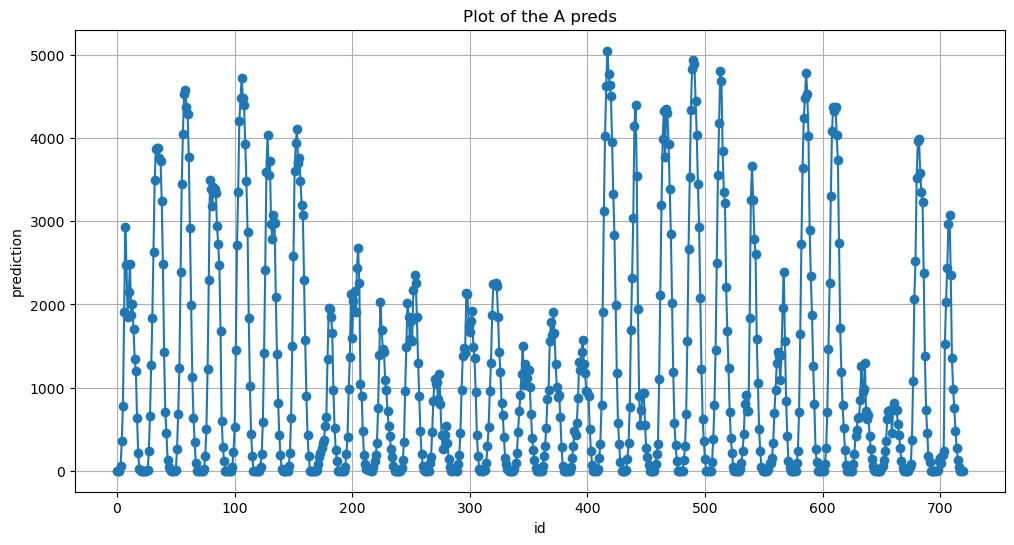

In [63]:
# Assuming 'result_df' is the DataFrame with the predictions
final_submission['id'] = final_submission.index

# Now 'first_720_rows' will also have the 'id' column
first_720_rows = final_submission.iloc[:720]

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(first_720_rows['id'], first_720_rows['prediction'], marker='o', linestyle='-')
plt.xlabel('id')
plt.ylabel('prediction')
plt.title('Plot of the A preds')
plt.grid(True)
plt.show()


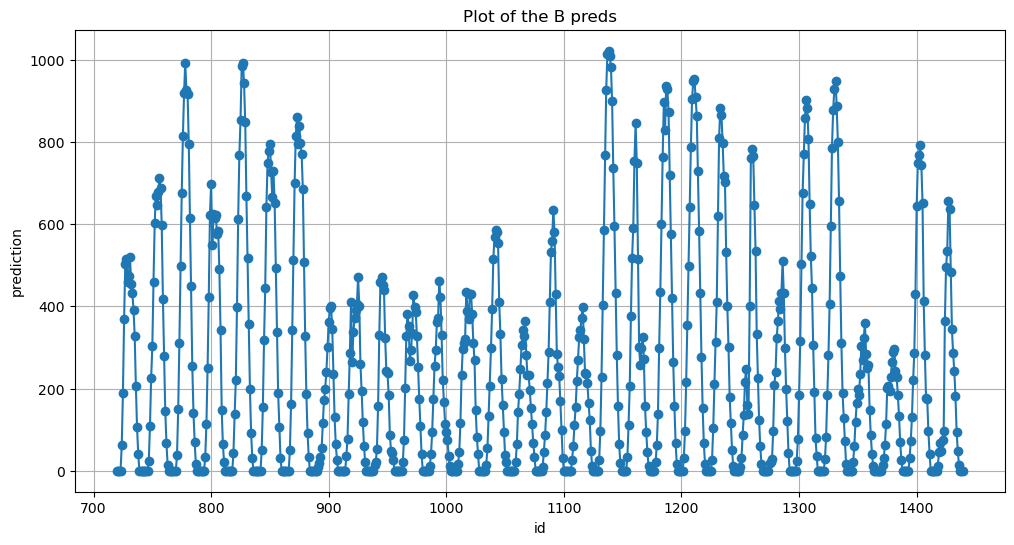

In [64]:
# Assuming you have 'result_df' containing the data
first_720_rows = final_submission.iloc[720:1440]

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(first_720_rows['id'], first_720_rows['prediction'], marker='o', linestyle='-')
plt.xlabel('id')
plt.ylabel('prediction')
plt.title('Plot of the B preds')
plt.grid(True)
plt.show()

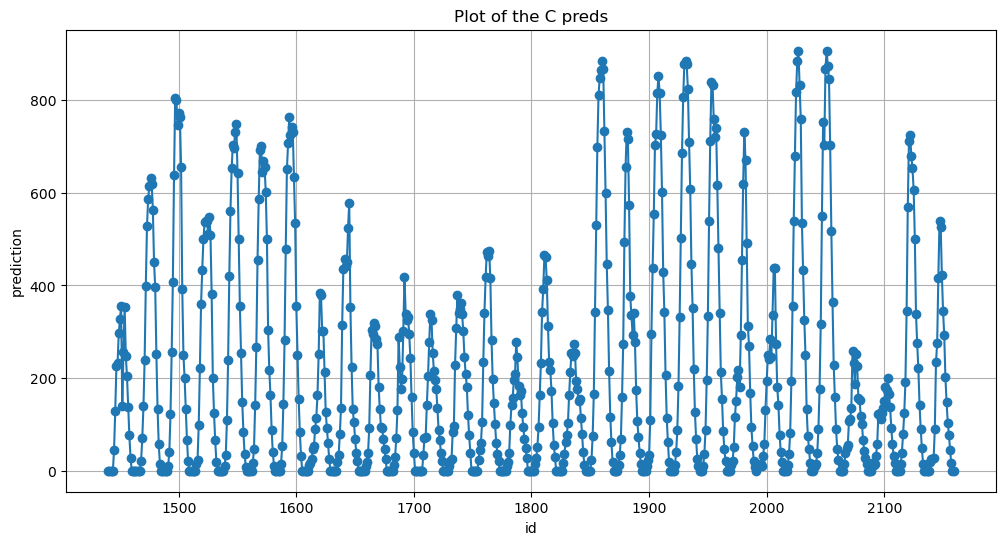

In [65]:
# Assuming you have 'result_df' containing the data
first_720_rows = final_submission.iloc[1440:]

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(first_720_rows['id'], first_720_rows['prediction'], marker='o', linestyle='-')
plt.xlabel('id')
plt.ylabel('prediction')
plt.title('Plot of the C preds')
plt.grid(True)
plt.show()